In [1]:
import numpy as np
import matplotlib.pyplot as plt
import strawberryfields as sf
from strawberryfields.ops import Ket, BSgate, Interferometer, Rgate, MeasureFock

In [22]:
cutoff_dim = 3  # (1+ total number of photons)
paths = 2
modes = 2 * paths

def bell_state(state_name): # 0: psi+, 1: psi-, 2: phi+, 3: phi-
    state = np.zeros([cutoff_dim] * modes, dtype='complex')
    
    str2int = {
        'psi+': 0,
        'psi-': 1,
        'phi+': 2,
        'phi-': 3
    }
    
    x = str2int[state_name]
    
    if x in [0,1]:
        state[1, 0, 0, 1] = 1/np.sqrt(2)
        state[0, 1, 1, 0] = (-1)**x/np.sqrt(2)
    elif x in [2,3]:
        state[1, 0, 1, 0] = 1/np.sqrt(2)
        state[0, 1, 0, 1] = (-1)**x/np.sqrt(2)
        
    return state

# Permutation Matrix (SWAP)
X = np.array([[0, 1], [1, 0]])

prog = sf.Program(modes)
phi = prog.params('phi')
initial_state = 'phi-'
with prog.context as q:
    Ket(bell_state(initial_state)) | q  # Initial state preparation
    Interferometer(X) | (q[1], q[3]) # Polarizing BS
    Rgate(np.pi) | q[1]
    Rgate(phi) | q[2]
    Rgate(phi) | q[3]
    Interferometer(X) | (q[0], q[1])
    BSgate() | (q[0], q[2])
    BSgate() | (q[1], q[3])
    MeasureFock() | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})

In [23]:
N = 50 # Number of shots
for i in range(N):
    result = eng.run(prog, args={'phi': np.pi/4.})
    state = result.state
    ket = state.ket()
    sample = result.samples[0]
    coincidence = (1 in sample[0:2])*(1 in sample[2:4])
    print('{}\t{}'.format(sample,coincidence))

[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[0 0 1 1]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[0 0 1 1]	0
[1 1 0 0]	0
[1 1 0 0]	0
[0 0 1 1]	0
[1 1 0 0]	0


In [24]:
M = 2**7 # Number of angles
phi = np.linspace(0,2*np.pi,M)
N = 500 # Number of shots
L = 30 # Number of repetitions per angle

coincidences = np.zeros((M,L))

for i in range(len(phi)):
    print(phi[i])
    for j in range(L):
        for l in range(N):
            result = eng.run(prog, args={'phi': phi[i]})
            state = result.state
            ket = state.ket()
            sample = result.samples[0]
            coincidences[i,j] += (1 in sample[0:2])*(1 in sample[2:4])
        
np.save('coincidences_{}_N{}_M{}_L{}'.format(initial_state,N,M,L), coincidences)

0.0
0.049473900056532176
0.09894780011306435
0.14842170016959652
0.1978956002261287
0.2473695002826609
0.29684340033919304
0.3463173003957252
0.3957912004522574
0.4452651005087896
0.4947390005653218
0.5442129006218539
0.5936868006783861
0.6431607007349183
0.6926346007914504
0.7421085008479826
0.7915824009045148
0.841056300961047
0.8905302010175792
0.9400041010741114
0.9894780011306435
1.0389519011871757
1.0884258012437078
1.13789970130024
1.1873736013567722
1.2368475014133045
1.2863214014698365
1.3357953015263688
1.385269201582901
1.4347431016394332
1.4842170016959653
1.5336909017524976
1.5831648018090296
1.6326387018655617
1.682112601922094
1.731586501978626
1.7810604020351584
1.8305343020916904
1.8800082021482227
1.9294821022047548
1.978956002261287
2.028429902317819
2.0779038023743515
2.1273777024308838
2.1768516024874156
2.226325502543948
2.27579940260048
2.3252733026570125
2.3747472027135443
2.4242211027700766
2.473695002826609
2.5231689028831408
2.572642802939673
2.62211670299620

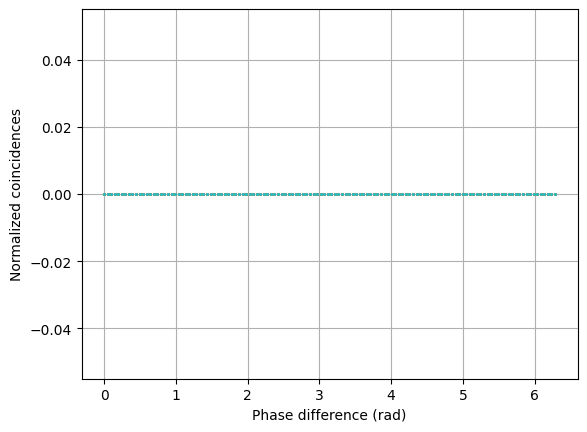

In [26]:
plt.figure()
plt.plot(phi, coincidences/N, 'o', markersize=1)
plt.ylabel('Normalized coincidences')
plt.xlabel('Phase difference (rad)')
plt.grid()
plt.show()